In [48]:
import torch                                                  #tensor related operations
import torchvision
import os
#import tarfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.models as models
#from torchvision.datasets.utils import download_url
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
dataset = CIFAR100(root = '/content/drive/MyDrive/data', transform = ToTensor())

In [50]:
test_dataset = CIFAR100(root = '/content/drive/MyDrive/data', train = False, transform = ToTensor())

In [51]:
#data preparation
torch.manual_seed(32) # for reproducibility
val_size = 10000
train_size = len(dataset) - val_size

In [52]:
# Random Split and Split of dataset between train and validation, randomness is important to have in the data! for performance of the model! that it sees everything during learning!
train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [53]:
#Batch Size, i start here by having 64
batch_size = 32 #гиперпараметр, его можно менять. в качестве допа можно построить график зависимости оценки от batch_size

In [54]:
# Defining Loaders for training process
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=2, pin_memory =True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory =True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory =True)

Shape of an Image (Batch Size, RGB, Pixels): torch.Size([32, 3, 32, 32])


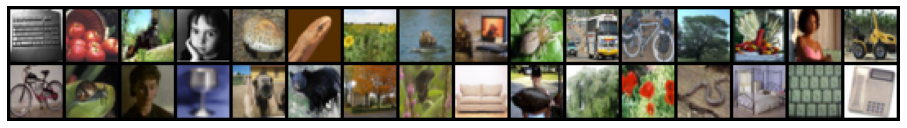

In [55]:
# For visualization purposes, we create our batch grid, to visually check how a batch would look like
for images, _ in train_loader: 
    print('Shape of an Image (Batch Size, RGB, Pixels):', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0))) # we need permute here because matplotlib wants to have the channels as the last dimension
    break

In [56]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch

        for i in range(len(labels)):
          if labels[i] == 8:
            labels[i] = 0
          elif labels[i] == 48:
            labels[i] = 1
          else:
            labels[i] = 2

        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch

        for i in range(len(labels)):
          if labels[i] == 8:
            labels[i] = 0
          elif labels[i] == 48:
            labels[i] = 1
          else:
            labels[i] = 2
             
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [57]:
class CIFAR100Model(ImageClassificationBase):
        def __init__(self):
                super().__init__()
                self.network = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
                num_ftrs = self.network.fc.in_features
                self.network.fc = nn.Linear(num_ftrs, 3)
        
        def forward(self, xb):
                return self.network(xb)
            
model = CIFAR100Model()
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


CIFAR100Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [58]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

CIFAR100Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [60]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, 
        weight_decay=0, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [61]:
# For this model we gonna use Adam Optimization
opt_func = torch.optim.Adam
weight_decay = 5e-4
grad_clip = 0.1

In [62]:
history = fit(3, 1e-3, model, train_dl, val_dl, weight_decay, opt_func)

Epoch [0], train_loss: 0.1018, val_loss: 0.0947, val_acc: 0.9786
Epoch [1], train_loss: 0.0818, val_loss: 0.0799, val_acc: 0.9805
Epoch [2], train_loss: 0.0704, val_loss: 0.0689, val_acc: 0.9818


In [63]:
result = evaluate(model, test_loader)
result

{'val_loss': 0.06524492055177689, 'val_acc': 0.981829047203064}